# Name Origin Identifier using RNN

**This project builds a PyTorch-based recurrent neural network (RNN) that identifies the origin of names. The RNN is trained on a total of 20074 names from 18 origins.**

An RNN is a neural network that can take sequences of inputs and produce output(s). In this project, the inputs are names. Hence, the alphabets in the names form a sequence of input which the RNN uses to predict the origin. For each alphabet in the name, the RNN calculates an output and a hidden state. The hidden state is passed on to the next layer as an input along with the next alphabet. Hidden states get passed on to the next layer recurrently until the RNN takes the final alphabet and final hidden state as the inputs to produce the output.

### Helper Functions 

First, let us define some helper function that will: 
- extract only the english alphabets from the names and drop any special characters.
- Load the datasets.
- Convert the data into tensors.

In [1]:
path = "Data"

In [2]:
import unicodedata #This module is used to read or breakdown unicode text
import string #We can import ascii letters by typing string.ascii_letters
import glob #This module extracts the file names
import io #This module is simply used for opening files
import os
import numpy as np
import random

import torch as torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
alphabets = 'abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ'
number_of_alphabets = len(alphabets)

In [4]:
def unicode_to_ascii(s): 
    s = "".join([c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c)!="Mn" and c in alphabets])
    #unicode.normalize breakdowns words into individual characters (including modifying characters such as the umlaut in German)
    #unicode.category(c)!='Mn' is saying that the character c is not a modifying character
    return s

In [5]:
def load_data():
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path) #Extracts all the file names including the paths
    
    def read_lines(filename):
        lines = io.open(filename, encoding="utf-8").read().strip().split("\n") #Produces a list of names from the file
        return [unicode_to_ascii(line) for line in lines]
    
    for file in find_files(f"{path}/*.txt"):
        category = os.path.splitext(os.path.basename(file))[0] #Extracts the filename excluding file extension
        all_categories.append(category)
        
        category_lines[category]=read_lines(file)
    
    return category_lines, all_categories

In [6]:
def alphabet_to_index(alphabet):
    return alphabets.index(alphabet)

In [7]:
def alphabet_to_tensor(alphabet):
    tensor = torch.zeros(1,number_of_alphabets)
    tensor[0, alphabet_to_index(alphabet)]=1
    return tensor

In [8]:
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, number_of_alphabets)
    #Think len(line) dfs with 1 row and number_of_alphabet columns
    #Each dataframe represents one line (in this case, line is actually a name)
    for index, alphabet in enumerate(line):
        tensor[index][0][alphabet_to_index(alphabet)] = 1
    return tensor

In [9]:
def load_random_input(category_lines, all_categories):
    category_idx = random.choice(np.arange(1,len(all_categories),1))
    category = all_categories[category_idx]
    
    line_idx = random.choice(np.arange(1,len(category_lines[category]),1))    
    line = category_lines[category][line_idx]
    
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    
    return category, line, category_tensor, line_tensor

In [10]:
def output_to_category(output):
        category_idx = torch.argmax(output).item() #The same as doing int(output.argmax()). This returns an int instead of tensor
        return all_categories[category_idx]

### Building the RNN Model

In [11]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        super(RNN, self).__init__() #Inheriting the attributes from the super class
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(self.input_size+self.hidden_size, self.hidden_size) #Instance of a linear layer X*A(Transpose) + B
        self.i2o = nn.Linear(self.input_size+self.hidden_size, self.output_size) #A and B can be optimized using optimizer
        self.softmax = nn.LogSoftmax(dim=1)
        self.criterion = nn.NLLLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim=1) #The same as concatenating a df along its columns 
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def training_step(self, line_tensor, category_tensor):
        hidden = self.init_hidden()
        
        for i in range(len(line_tensor)): #Because we have to run a forward pass for each alphabet to get the final output
            output, hidden = self.forward(line_tensor[i], hidden)
        
        loss = self.criterion(output, category_tensor) #The criterion compares the log probabilities of output and category tensors
        
        self.optimizer.zero_grad() #Sets all gradients to zero
        loss.backward() #Calculates all the gradients of the loss w.r.t. the rnn parameters
        self.optimizer.step() #Takes a step to change the parameters based on the calculated gradients
        
        return output, loss.item() #loss.item() returns loss as an integer instead of a tensor
            
    def train(self, category_lines, all_categories, number_of_iterations):
        plot_steps, print_steps = number_of_iterations/100, number_of_iterations/20 
        all_losses = []
        sum_of_losses = 0
        
        for i in range(0, number_of_iterations):
            category, line, category_tensor, line_tensor = load_random_input(category_lines, all_categories)
            output, loss = self.training_step(line_tensor, category_tensor)
            sum_of_losses += loss
            
            if (i+1)%plot_steps == 0:
                all_losses.append(sum_of_losses/plot_steps)
                sum_of_losses = 0

            if (i+1)%print_steps == 0:
                guess = output_to_category(output)
                if guess==category:
                    correct = f"Guess: {guess} | Correct/Wrong: Correct" 
                else: 
                    correct = f"Guess: {guess} | Correct/Wrong: Wrong ({category})"
                    
                print(f"{i+1}th iteration | loss:{loss} | Name: {line} | {correct}")
        
        plt.figure()
        plt.plot(all_losses)
        ax=plt.gca()
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        plt.show
        
    def predict(self, input_line):
        with torch.no_grad():
            input_tensor = line_to_tensor(input_line)
            hidden_tensor = self.init_hidden()
            for i in range(len(input_line)): #Because we have to run a forward pass for each alphabet to get the final output
                output, hidden_tensor = rnn.forward(input_tensor[i], hidden_tensor)

        prediction = output_to_category(output)
        print(f"Name: {input_line} | Origin: {prediction}")

### Understanding how the RNN is trained

nn.Linear creates an instance of a linear layer **(performing linear transformation X*A(Transpose) + B)** where A and B are parameters that can be optimized using the optimzer. nn.Linear takes two arguments in_features, out_features, which are the number of features (columns) in the input and the number of features (columns) in the output respectively.

In [12]:
LL = nn.Linear(2,1) 

nn.Linear initializes the weights (**A**) and biases (**B**) by itself but we can manually initialize it if we want. In the following cell, they have been initialized. 

In [13]:
LL.weight = nn.Parameter(torch.tensor([[1.0, 1.0]]))
LL.bias = nn.Parameter(torch.tensor([[1.0]]))

In the following cell, a linear transformation has been applied to a tensor using the **"LL"** linear layer.

In [14]:
LL(torch.tensor([[1.0,2.0],[4.0,5.0]]))

tensor([[ 4.],
        [10.]], grad_fn=<AddmmBackward0>)

The linear transformation applied by nn.Linear can be thought of as the following operation, which has been performed on the numpy array.

In [15]:
import numpy as np
np.matmul([[1.0,2.0],[4.0,5.0]], np.array([[1.0, 1.0]]).T) + [[1.0]]

array([[ 4.],
       [10.]])

### Training the RNN model 

In [16]:
category_lines, all_categories = load_data()
number_of_categories = len(all_categories)

rnn = RNN(number_of_alphabets, 128, number_of_categories, 0.005)

5000th iteration | loss:2.1465768814086914 | Name: Golosenko | Guess: Russian | Correct/Wrong: Correct
10000th iteration | loss:2.2102484703063965 | Name: Terauchi | Guess: Italian | Correct/Wrong: Wrong (Japanese)
15000th iteration | loss:2.0404157638549805 | Name: Nunez | Guess: Dutch | Correct/Wrong: Wrong (Spanish)
20000th iteration | loss:1.4953036308288574 | Name: Kieu | Guess: Vietnamese | Correct/Wrong: Correct
25000th iteration | loss:1.847130537033081 | Name: Douglas | Guess: Greek | Correct/Wrong: Wrong (Scottish)
30000th iteration | loss:2.219425678253174 | Name: Langbroek | Guess: Scottish | Correct/Wrong: Wrong (Dutch)
35000th iteration | loss:2.9263148307800293 | Name: Cann | Guess: Korean | Correct/Wrong: Wrong (Dutch)
40000th iteration | loss:0.998504638671875 | Name: Chai | Guess: Chinese | Correct/Wrong: Correct
45000th iteration | loss:0.24409663677215576 | Name: Mitsuya | Guess: Japanese | Correct/Wrong: Correct
50000th iteration | loss:0.22554154694080353 | Name: 

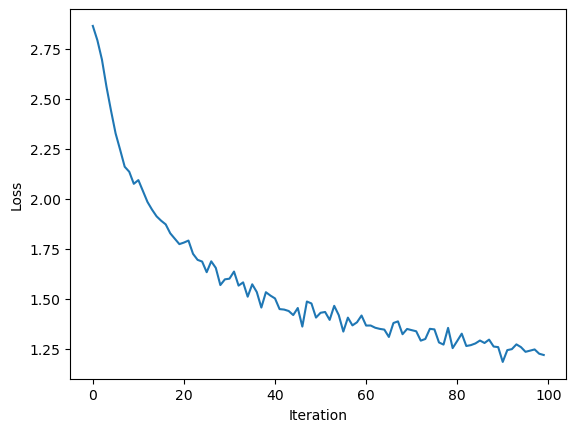

In [17]:
rnn.train(category_lines, all_categories, 100000)

### Testing the RNN Model

In [19]:
rnn.predict("Adam")

Name: Adam | Origin: Irish


### References 

https://www.youtube.com/watch?v=WEV61GmmPrk